[LightGBM] [Info] Number of positive: 4049, number of negative: 3951
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506125 -> initscore=0.024501
[LightGBM] [Info] Start training from score 0.024501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
F1_score
0.5792120704107293


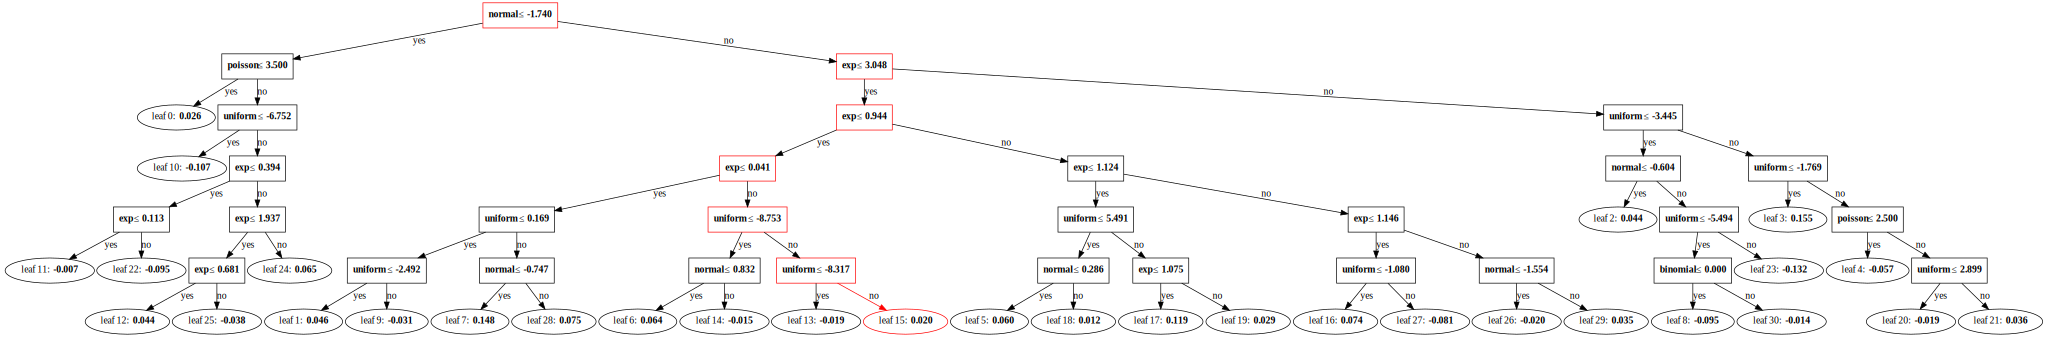

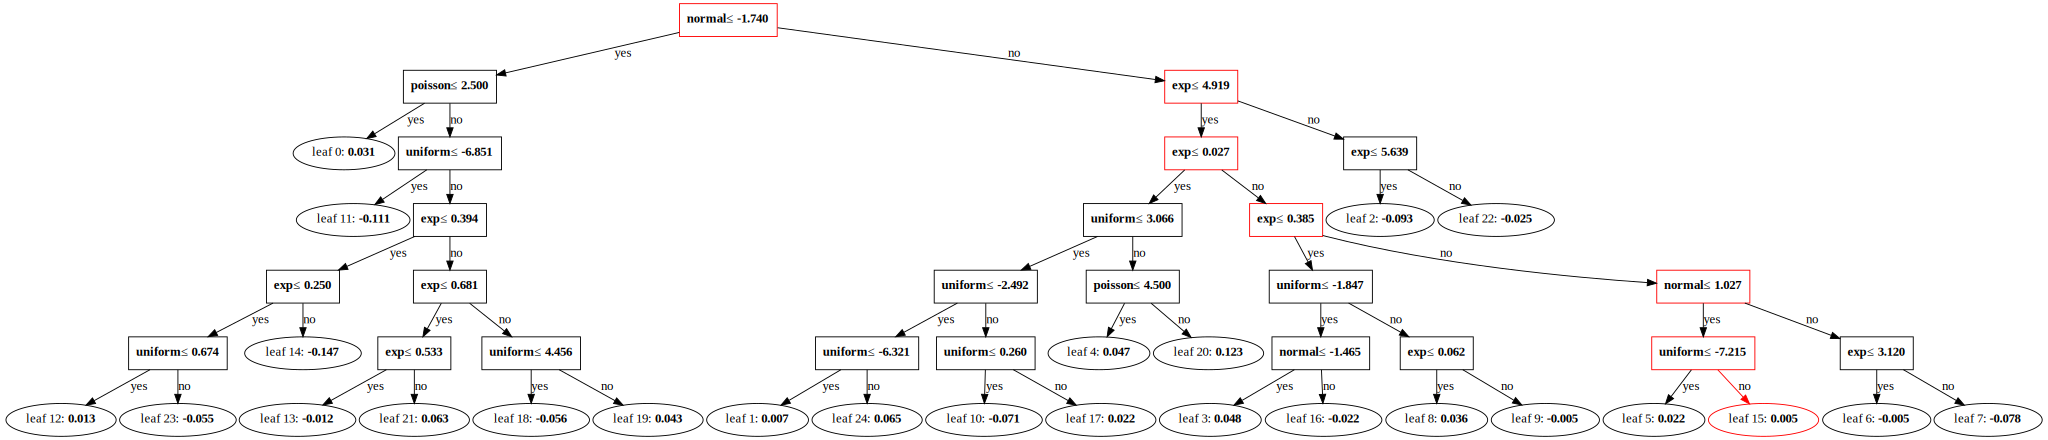

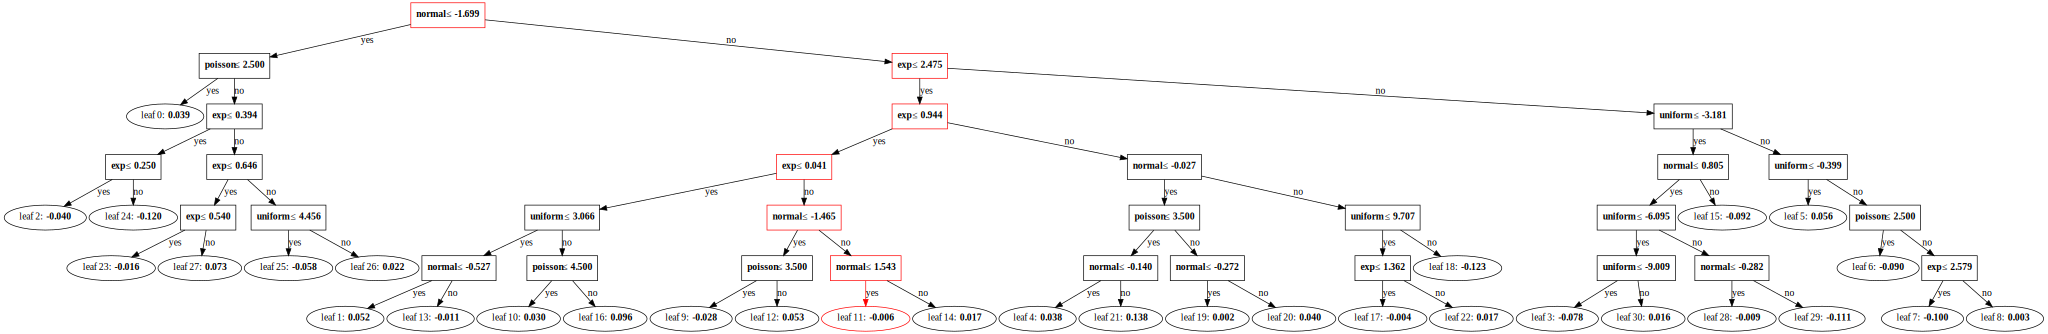

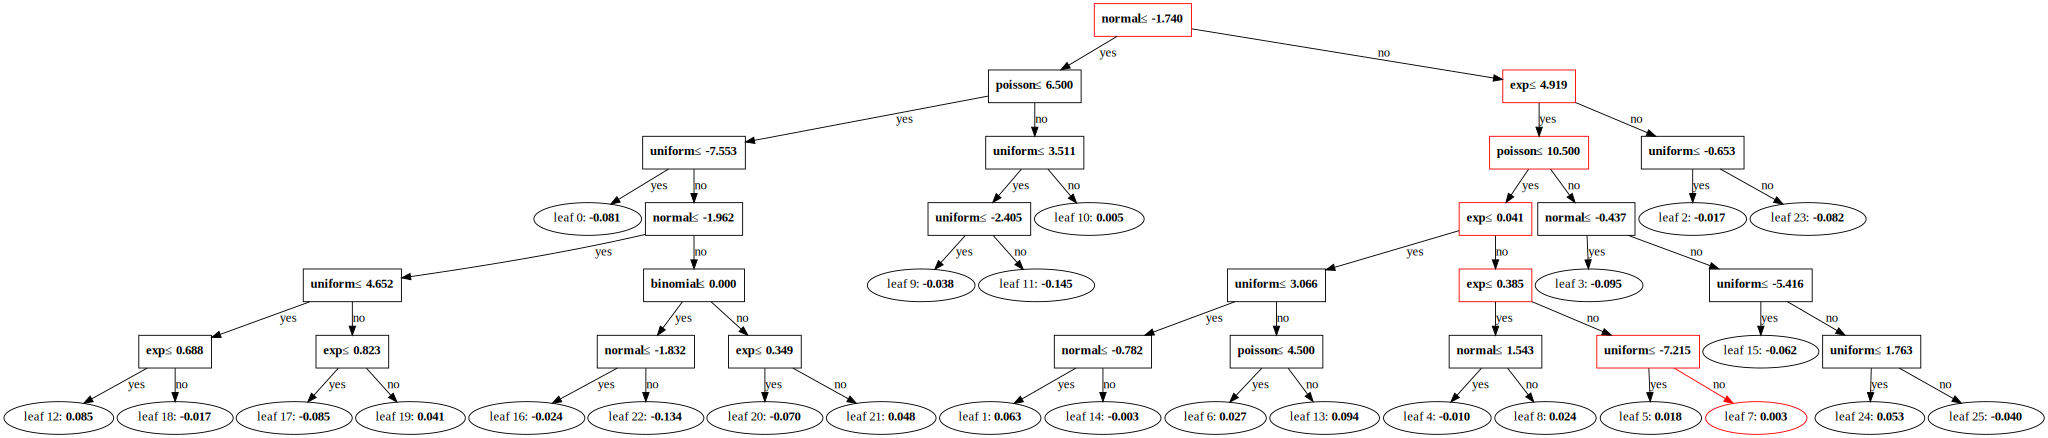

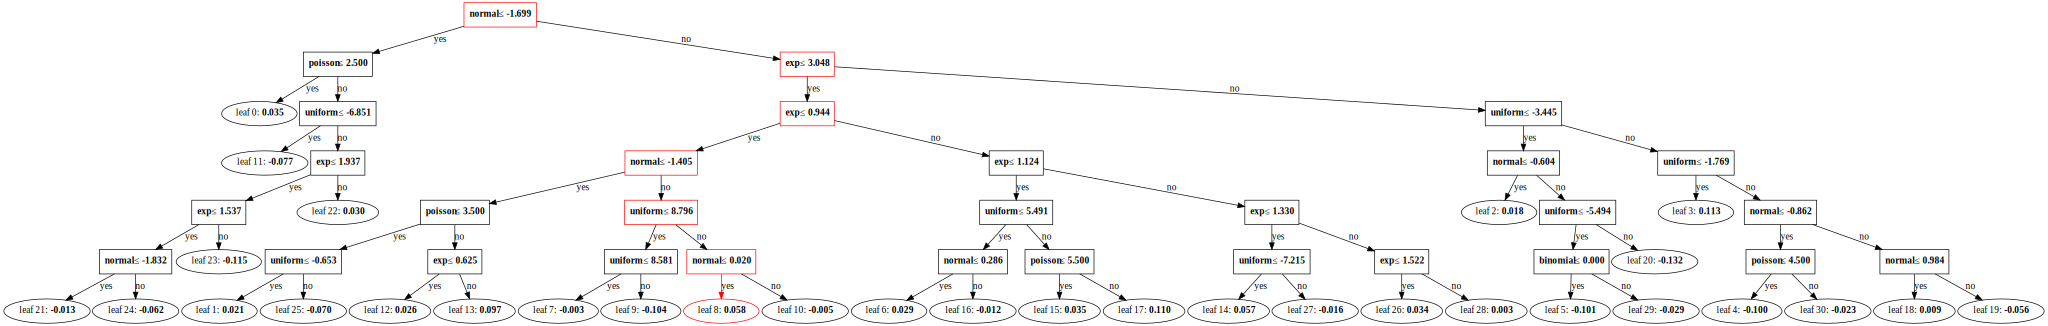

In [99]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import graphviz
from IPython.display import Image, display
from sklearn.metrics import f1_score
import re

def visualize_tree_paths(model, object_index, n_trees=None):
    def predict_path(tree_structure, sample):
        current_node = tree_structure
        path = []
        while 'leaf_index' not in current_node:
            feature_idx = current_node['split_feature']
            threshold = current_node['threshold']
            feature_value = sample.iloc[feature_idx]
            path.append({
                'feature': feature_idx,
                'threshold': threshold,
                'value': feature_value,
                'direction': '<=' if feature_value <= threshold else '>'
            })
            if feature_value <= threshold:
                current_node = current_node['left_child']
            else:
                current_node = current_node['right_child']
        return path, current_node

    first_object = X_test.iloc[object_index]
    columns = data.columns
    dumped_model = model.booster_.dump_model()

    if n_trees is None:
        n_trees = model.n_estimators

    for tree_index in range(n_trees):
        tree_info = dumped_model['tree_info'][tree_index]['tree_structure']
        path, leaf = predict_path(tree_info, first_object)
        leaf = leaf['leaf_index']

        dot_data = lgb.create_tree_digraph(model.booster_, orientation='vertical', tree_index=tree_index)
        dot_source = dot_data.source

        highlighted_lines = []
        for line in dot_source.splitlines():
            find = False
            for item in path:
                f = columns[item['feature']]
                if re.search(rf'\b{f}\b', line) and str(round(item['threshold'], 3)) in line:
                    highlighted_lines.append(line.replace('color=black', 'color=red'))
                    find = True
                    break
            if not find and re.search(rf'\bleaf{leaf}\b', line):
                highlighted_lines.append(line.replace('color=black', 'color=red'))
                find = True
            if not find:
                highlighted_lines.append(line)


        highlighted_dot_source = "\n".join(highlighted_lines)
        highlighted_graph = graphviz.Source(highlighted_dot_source)
        display(highlighted_graph)


n_samples = 10000
normal_feature = np.random.normal(loc=0, scale=1, size=n_samples)
uniform_feature = np.random.uniform(low=-10, high=10, size=n_samples)
binomial_feature = np.random.binomial(n=1, p=0.5, size=n_samples)
exp_feature = np.random.exponential(scale=1, size=n_samples)
poisson_feature = np.random.poisson(lam=5, size=n_samples)
target = np.random.choice([0, 1], size=n_samples)

data = pd.DataFrame({
    'normal': feature_1,
    'uniform': feature_2,
    'binomial': feature_3,
    'exp': feature_4,
    'poisson': feature_5,
    'Target': target
})

X = data.drop('Target', axis=1)
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(objective='binary', n_estimators=5, max_depth=6, random_state=42)
model.fit(X_train, y_train)

print('F1_score')
print(f1_score(y_test, model.predict(X_test)))

# Вызов функции для визуализации путей по дереву
visualize_tree_paths(model, object_index=0)  # Пример вызова функции